## Data Engineering

This notebook is part of the Credit Loan project and is dedicated to deep feature synthesis (DFS) 

Because the data is spread out among 7 tables, we can aggregate and create synthetic features automatically saving time and eliminating most of the grunt work. This method takes into account the child/parent relationships of the tables and aggregates features by common index creating aggregated and transformed feature matrix. 

Another benefit of DFS is that the automatic transformation and aggregation of features allows us to capture data patterns without too much domain knowledge

In our particular case the target table is Application to which all of the new aggregations will be added in a resulting feature matrix. Since the target table is not being aggregated or transformed we don't need to drop any features from it to avoid data leakage.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "src"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

Import few modules needed for the operations

In [3]:
import pandas as pd
import numpy as np
import featuretools as ft
from woodwork.logical_types import Boolean

import utils

In [4]:
import warnings

warnings.filterwarnings("ignore")

Import the data tables, the default "365243" value appearing in the dataset and a default, so we will change it to NaN so we can avoid features being created out of the numeric placeholder.

In [6]:
application = utils.reduce_df_memory(
    pd.read_csv("../data/application_train.csv").replace({365243: np.nan})
)
bureau = utils.reduce_df_memory(
    pd.read_csv("../data/bureau.csv").replace({365243: np.nan})
)
bureau_balance = utils.reduce_df_memory(
    pd.read_csv("../data/bureau_balance.csv").replace({365243: np.nan})
)
credit = utils.reduce_df_memory(
    pd.read_csv("../data/credit_card_balance.csv").replace({365243: np.nan})
)
installment = utils.reduce_df_memory(
    pd.read_csv("../data/installments_payments.csv").replace({365243: np.nan})
)
pos = utils.reduce_df_memory(
    pd.read_csv("../data/POS_CASH_balance.csv").replace({365243: np.nan})
)
prev_app = utils.reduce_df_memory(
    pd.read_csv("../data/previous_application.csv").replace({365243: np.nan})
)

The schema for the data:

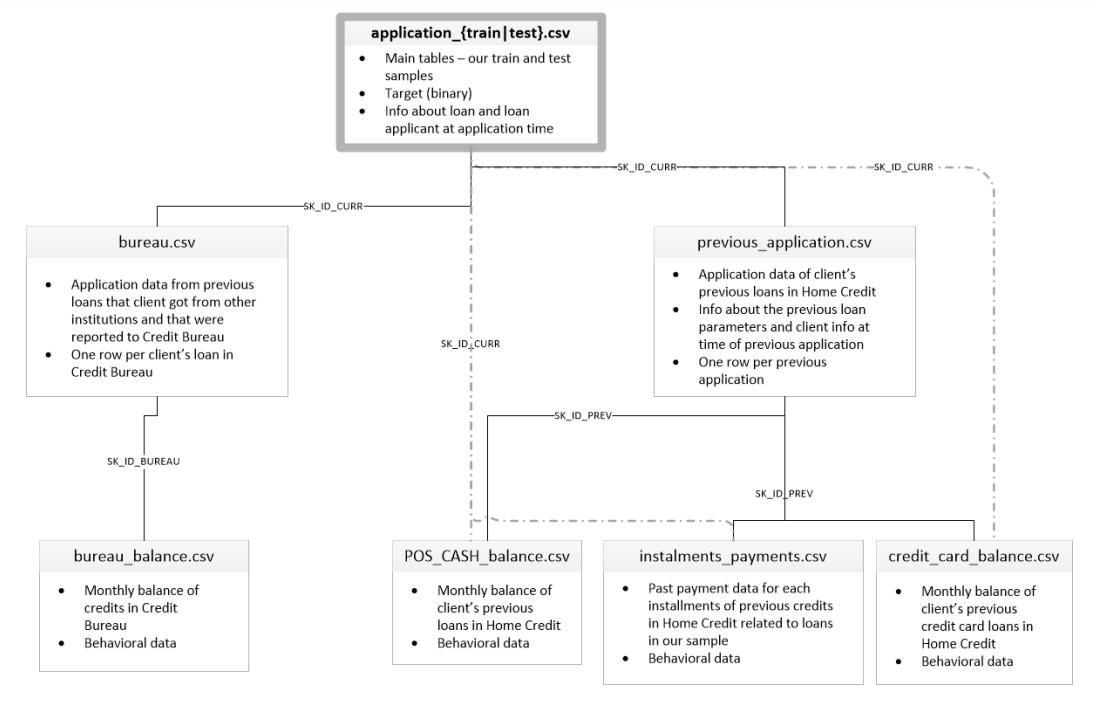

Featuretools requires all indexes to be of the same datatype, to make sure we don't get any unexpected errors all common indexes outlined in data schema will be set to integer datatype

In [7]:
for index in ["SK_ID_CURR", "SK_ID_PREV", "SK_ID_BUREAU"]:
    for dataset in [
        application,
        bureau,
        bureau_balance,
        credit,
        installment,
        pos,
        prev_app,
    ]:
        if index in list(dataset.columns):
            dataset[index] = dataset[index].fillna(0).astype(np.int64)

We will also set the datatypes (called logic types in featuretools) to avoid incorrect aggregations being made automatically, as an example we don't want means or medians for boolean/binary features

In [16]:
application_log_types = {}

for col in application:
    if application[col].nunique() == 2:
        application_log_types[col] = Boolean

To enable featuretools an entity set has to be created which represents the relationship of the data

In [20]:
ent_set = ft.EntitySet(id="records")

For the entity set to function properly and for DFS to follow the logic of the data schema we will remove additional unique ID columns to make sure parent table to child/grandchild only has one path.

In [ ]:
installment = installment.drop(columns=["SK_ID_CURR"])
pos = pos.drop(columns=["SK_ID_CURR"])
credit = credit.drop(columns=["SK_ID_CURR"])

Next we add all of the imported dataframes into the entity set 

In [21]:
ent_set = ent_set.add_dataframe(
    dataframe=application,
    dataframe_name="application",
    index="SK_ID_CURR",
    logical_types=application_log_types,
)
ent_set = ent_set.add_dataframe(
    dataframe=bureau, dataframe_name="bureau", index="SK_ID_BUREAU"
)
ent_set = ent_set.add_dataframe(
    dataframe=prev_app, dataframe_name="prev_app", index="SK_ID_PREV"
)

ent_set = ent_set.add_dataframe(
    dataframe=bureau_balance,
    dataframe_name="bureau_balance",
    make_index=True,
    index="bureau_balance_index",
)
ent_set = ent_set.add_dataframe(
    dataframe=credit, dataframe_name="credit", make_index=True, index="credit_index"
)
ent_set = ent_set.add_dataframe(
    dataframe=installment,
    dataframe_name="installment",
    make_index=True,
    index="installment_index",
)
ent_set = ent_set.add_dataframe(
    dataframe=pos, dataframe_name="pos", make_index=True, index="pos_index"
)

Once the entity is set we can define the relationships by index provided in data schema

In [14]:
ent_set.add_relationship("application", "SK_ID_CURR", "bureau", "SK_ID_CURR")
ent_set.add_relationship("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU")
ent_set.add_relationship("application", "SK_ID_CURR", "prev_app", "SK_ID_CURR")

ent_set.add_relationship("prev_app", "SK_ID_PREV", "credit", "SK_ID_PREV")
ent_set.add_relationship("prev_app", "SK_ID_PREV", "installment", "SK_ID_PREV")
ent_set.add_relationship("prev_app", "SK_ID_PREV", "pos", "SK_ID_PREV")

Entityset: records
  DataFrames:
    application [Rows: 307511, Columns: 122]
    bureau [Rows: 1716428, Columns: 17]
    prev_app [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    credit [Rows: 3840312, Columns: 23]
    installment [Rows: 13605401, Columns: 8]
    pos [Rows: 10001358, Columns: 8]
  Relationships:
    bureau.SK_ID_CURR -> application.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    prev_app.SK_ID_CURR -> application.SK_ID_CURR
    credit.SK_ID_PREV -> prev_app.SK_ID_PREV
    installment.SK_ID_PREV -> prev_app.SK_ID_PREV
    pos.SK_ID_PREV -> prev_app.SK_ID_PREV

We can provide a list of aggregates that the DFS methods will perform on the specified entity set. The resulting feature names from the synthesis will have aggregation appended to it, so we can identify the usefulness and impact of these features for our model.

In [125]:
agg_primitives = [
    "sum",
    "max",
    "min",
    "mean",
    "count",
    "percent_true",
    "num_unique",
    "mode",
]

And finally initialize the DFS process with defined aggregations and max depth = "2" . Because we have parent->child-> grandchild relationship in the schema, max depth 1 would only include parent->child tables.

In [177]:
feature_matrix, feature_names = ft.dfs(
    entityset=ent_set,
    target_dataframe_name="application",
    agg_primitives=agg_primitives,
    max_depth=2,
    features_only=False,
)

We can save the resulting feature matrix for further use in modelling.

In [178]:
output = "../data/engineered_feat.csv"
feature_matrix.to_csv(output, index=False)

## Possible improvements

- Provide a full aggregation and transformation lists for synthetic feature engineering. This will result in exponentially higher computation times, but might yield some more effective or informative features for the dataset.
- Add DFS transformer into the full data pipepline (it is excluded from this project to save resources)